## Seq2Seq LSTM model for predicting future consumption

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim
import functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from importlib import reload
reload(functions)

<module 'functions' from 'c:\\Python64\\ADAML_GW\\adaml-ml-project\\functions.py'>

### Read the dataset

In [2]:
#Read dataset
path = "household_power_consumption.txt"
df = functions.load_data(path)

#Preprocess dataset and convert to hourly
df_hourly = functions.preprocess_data(df).reset_index()
df_hourly.head()

,datetime,Global_active_power,Global_reactive_power,Global_intensity,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-17 00:00:00,1.882467,0.102433,8.126667,240.961833,0.0,0.466667,0.000000
1,2006-12-17 01:00:00,3.349400,0.136933,14.246667,240.448333,0.0,25.233333,0.000000
2,2006-12-17 02:00:00,1.587267,0.078233,6.870000,245.818667,0.0,0.566667,0.000000
3,2006-12-17 03:00:00,1.662200,0.079533,7.206667,244.513500,0.0,0.766667,0.000000
4,2006-12-17 04:00:00,2.215767,0.093467,9.333333,243.855500,0.0,0.566667,8.883333


### Add features
Here we add time-related features: hour, weekday and day of the year. We use sin and cosine transforms instead of hot-encoded variables to make training faster.

We also use lagged measurements to utilize previous measurements.

In [3]:
#Add time variables: weekday, hour and day of year. Use sin/cosine transforms
df_hourly["hour_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.hour)/24)
df_hourly["hour_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.hour)/24)

df_hourly["weekday_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)
df_hourly["weekday_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)

df_hourly["day_of_year_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)
df_hourly["day_of_year_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)


In [59]:

df_hourly

,datetime,Global_active_power,Global_reactive_power,Global_intensity,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour_sin,hour_cos,weekday_sin,weekday_cos,day_of_year_sin,day_of_year_cos
0,2006-12-17 00:00:00,1.882467,0.102433,8.126667,240.961833,0.0,0.466667,0.000000,0.000000,1.000000,-0.781831,0.623490,-0.238673,0.971100
1,2006-12-17 01:00:00,3.349400,0.136933,14.246667,240.448333,0.0,25.233333,0.000000,0.258819,0.965926,-0.781831,0.623490,-0.238673,0.971100
2,2006-12-17 02:00:00,1.587267,0.078233,6.870000,245.818667,0.0,0.566667,0.000000,0.500000,0.866025,-0.781831,0.623490,-0.238673,0.971100
3,2006-12-17 03:00:00,1.662200,0.079533,7.206667,244.513500,0.0,0.766667,0.000000,0.707107,0.707107,-0.781831,0.623490,-0.238673,0.971100
4,2006-12-17 04:00:00,2.215767,0.093467,9.333333,243.855500,0.0,0.566667,8.883333,0.866025,0.500000,-0.781831,0.623490,-0.238673,0.971100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34555,2010-11-25 19:00:00,2.330467,0.151567,9.800000,237.729667,0.0,0.666667,8.366667,-0.965926,0.258819,0.433884,-0.900969,-0.580800,0.814046
34556,2010-11-25 20:00:00,1.647833,0.098033,6.826667,241.659000,0.0,0.550000,0.000000,-0.866025,0.500000,0.433884,-0.900969,-0.580800,0.814046
34557,2010-11-25 21:00:00,1.342933,0.049433,5.540000,240.698833,0.0,0.000000,0.000000,-0.707107,0.707107,0.433884,-0.900969,-0.580800,0.814046
34558,2010-11-25 22:00:00,1.247567,0.078933,5.160000,241.979500,0.0,0.000000,5.300000,-0.500000,0.866025,0.433884,-0.900969,-0.580800,0.814046


In [4]:
class EnergyData(Dataset):
    def __init__(self, features, targets, window,horizon):
        self.features = features
        self.targets = targets
        self.window = window
        self.horizon = horizon
        
    def __getitem__(self, index):
        x = self.features[index:index+self.window]
        y = self.targets[(index+self.window):(index+self.window+self.horizon)]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features) - self.window - self.horizon

In [5]:
last_year = len(df_hourly) - 24*365

# Split data into training/validation and test sets, last year for testing
train_val_data = df_hourly.iloc[:last_year]
test_data = df_hourly.iloc[last_year:]


train_data,val_data = train_test_split(train_val_data,test_size=0.3,shuffle=False)

In [21]:
#Lookback window and horizon
window = 168
horizon = 24

batch_size = 128


Y_train = train_data["Global_active_power"].values
X_train = train_data.iloc[:, 1:len(train_data.columns)].values

X_val = val_data.iloc[:, 1:len(val_data.columns)].values
Y_val = val_data["Global_active_power"].values

#Scaler initialization
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

#Scaling
train_X = scalerX.fit_transform(X_train)
val_X = scalerX.transform(X_val)

train_Y = scalerY.fit_transform(Y_train.reshape(-1, 1))
val_Y = scalerY.transform(Y_val.reshape(-1, 1))

trainData = EnergyData(train_X, train_Y, window, horizon)
valData = EnergyData(val_X, val_Y, window, horizon)

trainLoader = DataLoader(trainData, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(valData, batch_size=batch_size, shuffle=True)


In [22]:

class Seq2SeqLSTM(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers,output_size):
        super().__init__()
        self.encoder = nn.LSTM(n_features,hidden_size,num_layers,batch_first=True,dropout=0.2)
        self.decoder = nn.LSTM(1,hidden_size,num_layers,batch_first=True,dropout=0.2)
        self.fc = nn.Linear(hidden_size,1)
        self.output_size = output_size
    def forward(self,X):
        # Encoding
        _, (h,c) = self.encoder(X)
        
        #Input for decoder
        decoder_input = torch.zeros(X.size(0),1,1,device=X.device)
        outputs = []

        for i in range(self.output_size):
            out, (h,c) = self.decoder(decoder_input, (h,c))
            y = self.fc(out)
            outputs.append(y)
            decoder_input = y
        return torch.cat(outputs,dim=1)

In [23]:

n_features  = 13
hidden_size = 64
num_layers = 2
output_size = 24


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = Seq2SeqLSTM(n_features=n_features,hidden_size=hidden_size,num_layers=num_layers,output_size=output_size)
loss_fn = nn.HuberLoss(delta=1)
optimizer = optim.Adam(model.parameters(), lr = 5*10**(-5))


epochs = 150
losses = []
model = model.to(device)
loss_fn = loss_fn.to(device)
model_path = "adaml_lstm_sub2.pth"
epoch_vector = np.linspace(1,epochs,epochs)
trainlossvector = np.linspace(1,epochs,epochs)
validlossvector = np.zeros(epoch_vector.shape)
min_validloss = np.inf
for epoch in range(epochs):
    trainlossvector[epoch] = functions.trainloop(trainLoader,model,loss_fn,optimizer,batch_size,device)
    min_validloss,validlossvector[epoch] = functions.validationloop(valLoader,model,loss_fn,min_validloss,device)
    #Save best model
    if min_validloss>=validlossvector[epoch]:
        min_validloss = validlossvector[epoch]
        torch.save(model.state_dict(),model_path)
    if (epoch+1)%1 == 0:
        print(f"Epoch: {epoch+1}/{epochs} | Average training loss {np.round(trainlossvector[epoch],5)}, Validation loss {np.round(validlossvector[epoch],5)}")
#torch.save(model.state_dict(),model_path)

Epoch: 1/150 | Average training loss 0.0198, Validation loss 0.00838
Epoch: 2/150 | Average training loss 0.01103, Validation loss 0.00809
Epoch: 3/150 | Average training loss 0.01086, Validation loss 0.00799
Epoch: 4/150 | Average training loss 0.01071, Validation loss 0.0079
Epoch: 5/150 | Average training loss 0.0106, Validation loss 0.00785
Epoch: 6/150 | Average training loss 0.01049, Validation loss 0.00779
Epoch: 7/150 | Average training loss 0.01033, Validation loss 0.00764
Epoch: 8/150 | Average training loss 0.01013, Validation loss 0.0075
Epoch: 9/150 | Average training loss 0.00999, Validation loss 0.00743
Epoch: 10/150 | Average training loss 0.00991, Validation loss 0.00737
Epoch: 11/150 | Average training loss 0.00981, Validation loss 0.00732
Epoch: 12/150 | Average training loss 0.00969, Validation loss 0.00724
Epoch: 13/150 | Average training loss 0.00958, Validation loss 0.00717
Epoch: 14/150 | Average training loss 0.00944, Validation loss 0.00703
Epoch: 15/150 | Ave

KeyboardInterrupt: 

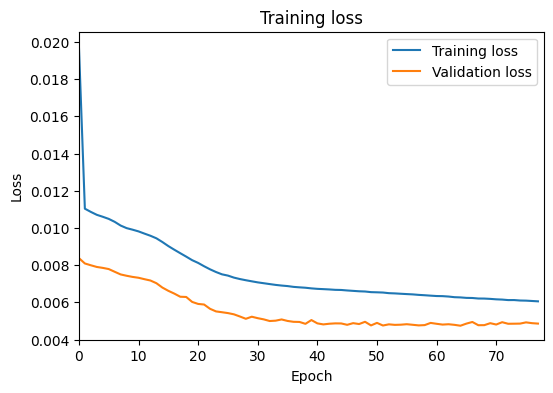

In [24]:

plt.figure(figsize=(6,4))
plt.plot(trainlossvector[:epoch],label="Training loss")
plt.plot(validlossvector[:epoch],label="Validation loss")
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(0,epoch)
plt.legend()
plt.show()

In [25]:
model_path = "adaml_lstm_sub2.pth"
n_features  = df_hourly.iloc[:,1:].shape[1]
hidden_size = 64
output_size = 24
num_layers = 2


prev_consumption = []
y_preds = []
y_actuals = []
model = Seq2SeqLSTM(n_features=n_features,hidden_size=hidden_size,num_layers=num_layers,output_size=output_size)
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()
model = model.to("cpu")




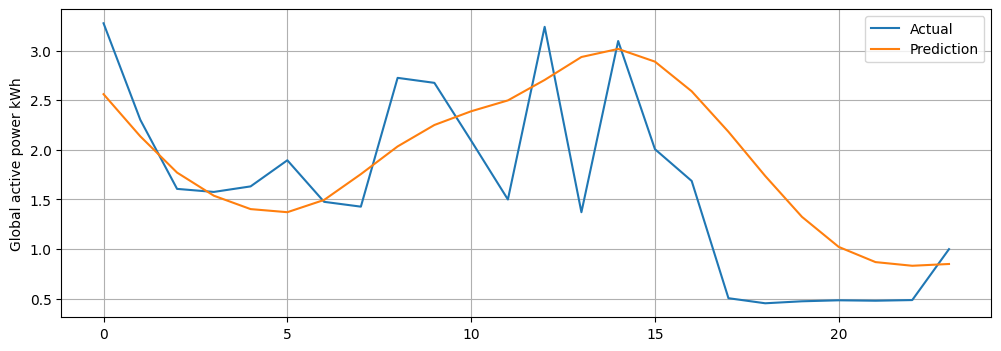

In [48]:
#Samples from validation data
i = 1

X_torch, y_actual = trainData.__getitem__(i)
y_actuals = y_actual.numpy()
with torch.no_grad():
    y_pred = model(X_torch.unsqueeze(0))
y_preds = y_pred.numpy()[0]
plt.figure(figsize=(12,4))
plt.plot(scalerY.inverse_transform(np.array(y_actuals).reshape(-1,1)),'-',label="Actual")
plt.plot(scalerY.inverse_transform(np.array(y_preds).reshape(-1,1)),label="Prediction")
plt.legend()
plt.grid()
plt.ylabel("Global active power kWh")
plt.show()